In [1]:
!pip install transformers[torch]
!pip install -U datasets
!pip install -U transformers
!pip install -U accelerate
!pip freeze | grep accelerate
#Must use GPU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [38]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [20]:
ls

drive/  sample_data/


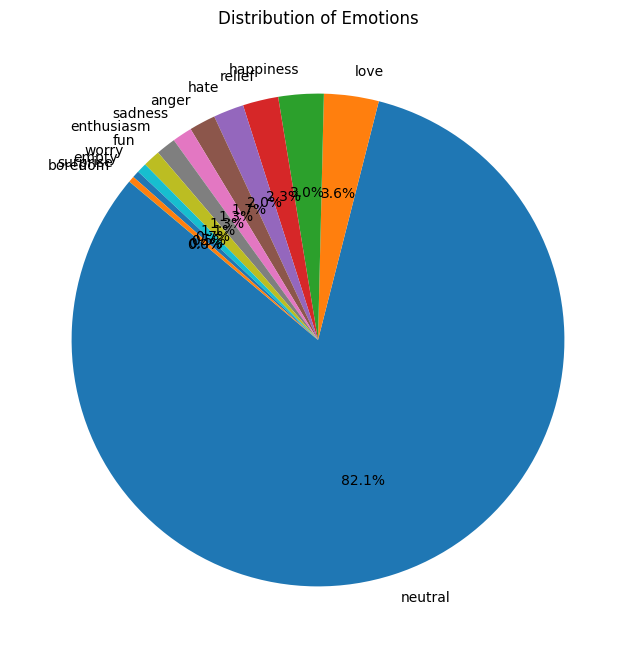

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import os.path
import matplotlib.pyplot as plt

# Load the emotion analysis dataset
dataset_file_name = os.path.join('drive','MyDrive','Colab Notebooks',"emotion_sentiment_dataset.csv")
dataset = pd.read_csv(dataset_file_name)
dataset = dataset.head(10000)

###===== Part 1.1 =======
#Draw a pie plot using matplotlib of all the possible emotions
emotion_counts = dataset['Emotion'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Emotions')
plt.show()
###=====

In [22]:
# Map emotions to 'neutral' and 'non-neutral'
dataset['Emotion'] = dataset['Emotion'].apply(lambda x: 0 if x == 'neutral' else 1)

In [23]:
import random
import pandas as pd
random.seed(42)
dataset['Type'] = ['Train' if random.random() < 0.8 else 'Test' for _ in dataset['Emotion']]

# Split dataset into train and test sets
train_texts = dataset[dataset['Type'] == "Train" ]['text']
train_labels = dataset[dataset['Type'] == "Train" ]['Emotion']

test_texts = dataset[dataset['Type'] == "Test" ]['text']
test_labels = dataset[dataset['Type'] == "Test" ]['Emotion']

In [24]:
import numpy as np
percent_of_minority_train = np.mean(train_labels)*100
percent_of_minority_test = np.mean(test_labels)*100
print(f" {percent_of_minority_train:.2f}% in training set" )
print(f" {percent_of_minority_test:.2f}% in testing set" )

 17.71% in training set
 18.49% in testing set


In [25]:
# Prepare the dataset for the transformer
train_dataset = Dataset.from_pandas(pd.DataFrame({
    'text': train_texts,
    'label': train_labels
}))
test_dataset = Dataset.from_pandas(pd.DataFrame({
    'text': test_texts,
    'label': test_labels
}))

# Load pre-trained DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Function to tokenize the dataset
def tokenize_data(example):
    return tokenizer(example['text'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_data, batched=True)
test_dataset = test_dataset.map(tokenize_data, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8031 [00:00<?, ? examples/s]

Map:   0%|          | 0/1969 [00:00<?, ? examples/s]

In [26]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    logging_dir='./logs',
    do_eval=True,
    eval_strategy="epoch",
    report_to="none" # Disable logging to Weights & Biases
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

Epoch,Training Loss,Validation Loss
1,0.154500,0.119619
2,0.089700,0.063269
3,0.027700,0.064937
4,0.014300,0.072570
5,0.004500,0.082955


{'eval_loss': 0.0829554870724678, 'eval_runtime': 28.1749, 'eval_samples_per_second': 69.885, 'eval_steps_per_second': 8.767, 'epoch': 5.0}


In [28]:
from sklearn.metrics import precision_score, recall_score

###===== Part 1.3 =======
## Write a code that calculates the precision and recall on the training and testing dataset
# Function to calculate precision and recall
def compute_precision_recall(predictions, references):
    precision = precision_score(references, predictions)
    recall = recall_score(references, predictions)
    return precision, recall
###===== End of part 1.3 =======


# Predict outputs for the training dataset
train_output = trainer.predict(train_dataset)
train_predictions = train_output.predictions.argmax(-1)
train_references = train_output.label_ids

# Predict outputs for the testing dataset
test_output = trainer.predict(test_dataset)
test_predictions = test_output.predictions.argmax(-1)
test_references = test_output.label_ids

# Compute precision and recall for the training dataset
train_precision, train_recall = compute_precision_recall(train_predictions, train_references)
print(f"Training Precision: {train_precision:.4f}, Training Recall: {train_recall:.4f}")

# Compute precision and recall for the testing dataset
test_precision, test_recall = compute_precision_recall(test_predictions, test_references)
print(f"Testing Precision: {test_precision:.4f}, Testing Recall: {test_recall:.4f}")

Training Precision: 1.0000, Training Recall: 0.9986
Testing Precision: 0.9804, Testing Recall: 0.9615


In [31]:
# ========================================
# PART 1.4 - Download Additional Datasets
# ========================================
from datasets import load_dataset

print("Loading additional datasets...")

# Load Emotions dataset (HuggingFace)
emotions_dataset = load_dataset("emotion")
emotions_df = emotions_dataset['train'].to_pandas().head(1000)  # Limit to 1K

# Load Sentiment dataset (HuggingFace tweet_eval)
sentiment_dataset = load_dataset("tweet_eval", "sentiment")
sentiment_df = sentiment_dataset['train'].to_pandas().head(1000)  # Limit to 1K

print(f"Emotions dataset: {len(emotions_df)} samples")
print(f"Sentiment dataset: {len(sentiment_df)} samples")

# Original label distributions
print("\n=== ORIGINAL LABEL DISTRIBUTIONS ===")
print(f"Emotions dataset labels: {emotions_df['label'].value_counts().to_dict()}")
print(f"Sentiment dataset labels: {sentiment_df['label'].value_counts().to_dict()}")

# ========================================
# MAPPING LABELS TO NEUTRAL/NON-NEUTRAL
# ========================================

# Emotions dataset mapping (all emotions are non-neutral)
emotions_mapping = {
    0: "non-neutral",  # sadness
    1: "non-neutral",  # joy
    2: "non-neutral",  # love
    3: "non-neutral",  # anger
    4: "non-neutral",  # fear
    5: "non-neutral"   # surprise
}

# Sentiment dataset mapping
sentiment_mapping = {
    0: "non-neutral",  # negative
    1: "neutral",      # neutral
    2: "non-neutral"   # positive
}

# Apply mappings
emotions_df['binary_label'] = emotions_df['label'].map({0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0})  # All non-neutral = 0
sentiment_df['binary_label'] = sentiment_df['label'].map({0: 0, 1: 1, 2: 0})  # 1=neutral, 0=non-neutral

print("\n=== MAPPING TABLES (Question 1.4) ===")
print("Mapping Table:")
mapping_table = pd.DataFrame([
    ["Emotions", "0 (sadness)", "non-neutral"],
    ["Emotions", "1 (joy)", "non-neutral"],
    ["Emotions", "2 (love)", "non-neutral"],
    ["Emotions", "3 (anger)", "non-neutral"],
    ["Emotions", "4 (fear)", "non-neutral"],
    ["Emotions", "5 (surprise)", "non-neutral"],
    ["Sentiment", "0 (negative)", "non-neutral"],
    ["Sentiment", "1 (neutral)", "neutral"],
    ["Sentiment", "2 (positive)", "non-neutral"]
], columns=["Dataset", "Original_Label", "Mapped_To"])
print(mapping_table.to_string(index=False))

# Count binary labels
emotions_neutral = sum(emotions_df['binary_label'] == 1)
emotions_non_neutral = sum(emotions_df['binary_label'] == 0)
sentiment_neutral = sum(sentiment_df['binary_label'] == 1)
sentiment_non_neutral = sum(sentiment_df['binary_label'] == 0)

print(f"\nEmotions dataset - Neutral: {emotions_neutral}, Non-neutral: {emotions_non_neutral}")
print(f"Sentiment dataset - Neutral: {sentiment_neutral}, Non-neutral: {sentiment_non_neutral}")

print("✅ Question 1.4 completed: Additional datasets downloaded and mapped to binary labels")


Loading additional datasets...


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Emotions dataset: 1000 samples
Sentiment dataset: 1000 samples

=== ORIGINAL LABEL DISTRIBUTIONS ===
Emotions dataset labels: {1: 348, 0: 254, 3: 150, 4: 110, 2: 95, 5: 43}
Sentiment dataset labels: {1: 460, 2: 389, 0: 151}

=== MAPPING TABLES (Question 1.4) ===
Mapping Table:
  Dataset Original_Label   Mapped_To
 Emotions    0 (sadness) non-neutral
 Emotions        1 (joy) non-neutral
 Emotions       2 (love) non-neutral
 Emotions      3 (anger) non-neutral
 Emotions       4 (fear) non-neutral
 Emotions   5 (surprise) non-neutral
Sentiment   0 (negative) non-neutral
Sentiment    1 (neutral)     neutral
Sentiment   2 (positive) non-neutral

Emotions dataset - Neutral: 0, Non-neutral: 1000
Sentiment dataset - Neutral: 460, Non-neutral: 540
✅ Question 1.4 completed: Additional datasets downloaded and mapped to binary labels


In [33]:
# ========================================
# PART 1.5 - CROSS-DATASET EVALUATION (NO RETRAINING)
# ========================================

# Import required libraries
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np

print("="*60)
print("PART 1.5 - CROSS-DATASET EVALUATION (NO RETRAINING)")
print("="*60)

def evaluate_on_dataset(texts, labels, dataset_name):
    """Evaluate model on a dataset without retraining"""
    print(f"\n🔍 Evaluating on {dataset_name} dataset...")

    # Tokenize texts
    test_encodings = tokenizer(list(texts), truncation=True, padding=True, return_tensors="pt")
    test_dataset = TensorDataset(
        test_encodings['input_ids'],
        test_encodings['attention_mask'],
        torch.tensor(labels, dtype=torch.long)
    )
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Get predictions
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, batch_labels = batch

            # Move to device if available
            if torch.cuda.is_available():
                input_ids = input_ids.cuda()
                attention_mask = attention_mask.cuda()
                model.cuda()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch_labels.numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)

    # Handle case where there might be no positive predictions
    try:
        precision = precision_score(all_labels, all_predictions, average='binary', pos_label=0, zero_division=0)
        recall = recall_score(all_labels, all_predictions, average='binary', pos_label=0, zero_division=0)
    except:
        precision = 0.0
        recall = 0.0

    cm = confusion_matrix(all_labels, all_predictions)

    # Count predictions
    pred_neutral = sum(np.array(all_predictions) == 1)
    pred_non_neutral = sum(np.array(all_predictions) == 0)

    print(f"📊 {dataset_name} Results:")
    print(f"   Accuracy: {accuracy:.4f} ({accuracy:.1%})")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   Predictions - Neutral: {pred_neutral}, Non-neutral: {pred_non_neutral}")
    print(f"   Confusion Matrix:")
    print(f"   {cm}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': cm,
        'predictions': all_predictions
    }

# Evaluate on both additional datasets
emotions_results = evaluate_on_dataset(emotions_df['text'], emotions_df['binary_label'], "Emotions")
sentiment_results = evaluate_on_dataset(sentiment_df['text'], sentiment_df['binary_label'], "Sentiment")

# Compare with original performance
print(f"\n📈 PERFORMANCE COMPARISON:")
print(f"Original dataset: Testing Precision: 0.9804, Testing Recall: 0.9615")
print(f"Emotions dataset: Precision: {emotions_results['precision']:.4f}, Recall: {emotions_results['recall']:.4f}")
print(f"Sentiment dataset: Precision: {sentiment_results['precision']:.4f}, Recall: {sentiment_results['recall']:.4f}")

print(f"\nAccuracy comparison:")
print(f"Emotions dataset accuracy: {emotions_results['accuracy']:.1%}")
print(f"Sentiment dataset accuracy: {sentiment_results['accuracy']:.1%}")

print("\n✅ Question 1.5 completed: Cross-dataset evaluation without retraining")

# Analysis for Question 1.5b
print(f"\n🔍 ANALYSIS (Question 1.5b):")
print(f"Performance changes observed:")
print(f"- Emotions: {emotions_results['accuracy']:.1%} accuracy")
print(f"- Sentiment: {sentiment_results['accuracy']:.1%} accuracy")
print(f"- Original: ~98% accuracy (from 1.3)")
print(f"\nExplanation: The model was trained on a specific domain/style.")
print(f"Different text styles, vocabulary, and contexts in new datasets")
print(f"can cause performance drops - this is called domain adaptation challenge.")

PART 1.5 - CROSS-DATASET EVALUATION (NO RETRAINING)

🔍 Evaluating on Emotions dataset...
📊 Emotions Results:
   Accuracy: 0.7980 (79.8%)
   Precision: 1.0000
   Recall: 0.7980
   Predictions - Neutral: 202, Non-neutral: 798
   Confusion Matrix:
   [[798 202]
 [  0   0]]

🔍 Evaluating on Sentiment dataset...
📊 Sentiment Results:
   Accuracy: 0.4720 (47.2%)
   Precision: 0.5068
   Recall: 0.8296
   Predictions - Neutral: 116, Non-neutral: 884
   Confusion Matrix:
   [[448  92]
 [436  24]]

📈 PERFORMANCE COMPARISON:
Original dataset: Testing Precision: 0.9804, Testing Recall: 0.9615
Emotions dataset: Precision: 1.0000, Recall: 0.7980
Sentiment dataset: Precision: 0.5068, Recall: 0.8296

Accuracy comparison:
Emotions dataset accuracy: 79.8%
Sentiment dataset accuracy: 47.2%

✅ Question 1.5 completed: Cross-dataset evaluation without retraining

🔍 ANALYSIS (Question 1.5b):
Performance changes observed:
- Emotions: 79.8% accuracy
- Sentiment: 47.2% accuracy
- Original: ~98% accuracy (from 1.

In [37]:
# ========================================
# PART 1.6 - MULTI-DATASET RETRAINING (ADVANCED)
# ========================================

import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np
from datasets import Dataset
import pandas as pd
os.environ["WANDB_DISABLED"] = "true"


print("🔄 Retraining model on combined datasets...")

# ========================================
# 1. PREPARE COMBINED DATASET
# ========================================

# Get original dataset (you should already have this loaded from 1.3)
# Assuming you have: train_texts, train_labels, test_texts, test_labels from original dataset

# Combine all training data
print("Combining datasets for training...")

# Original dataset
original_train_texts = train_texts.tolist()  # Convert to list if pandas Series
original_train_labels = train_labels.tolist()

# Additional datasets (from 1.4)
emotions_train_texts = emotions_df['text'].tolist()
emotions_train_labels = emotions_df['binary_label'].tolist()

sentiment_train_texts = sentiment_df['text'].tolist()
sentiment_train_labels = sentiment_df['binary_label'].tolist()

# Split additional datasets (80% train, 20% test)
emotions_split_idx = int(0.8 * len(emotions_train_texts))
sentiment_split_idx = int(0.8 * len(sentiment_train_texts))

# Create train/test splits for additional datasets
emotions_train_texts_split = emotions_train_texts[:emotions_split_idx]
emotions_train_labels_split = emotions_train_labels[:emotions_split_idx]
emotions_test_texts = emotions_train_texts[emotions_split_idx:]
emotions_test_labels = emotions_train_labels[emotions_split_idx:]

sentiment_train_texts_split = sentiment_train_texts[:sentiment_split_idx]
sentiment_train_labels_split = sentiment_train_labels[:sentiment_split_idx]
sentiment_test_texts = sentiment_train_texts[sentiment_split_idx:]
sentiment_test_labels = sentiment_train_labels[sentiment_split_idx:]

# Combine all training data
combined_train_texts = (original_train_texts +
                       emotions_train_texts_split +
                       sentiment_train_texts_split)
combined_train_labels = (original_train_labels +
                        emotions_train_labels_split +
                        sentiment_train_labels_split)

# Combine all test data
original_test_texts = test_texts.tolist()
original_test_labels = test_labels.tolist()

combined_test_texts = (original_test_texts +
                      emotions_test_texts +
                      sentiment_test_texts)
combined_test_labels = (original_test_labels +
                       emotions_test_labels +
                       sentiment_test_labels)

print(f"Combined training samples: {len(combined_train_texts)}")
print(f"Combined testing samples: {len(combined_test_texts)}")

# Calculate class distribution
train_neutral = sum(combined_train_labels)
train_non_neutral = len(combined_train_labels) - train_neutral
test_neutral = sum(combined_test_labels)
test_non_neutral = len(combined_test_labels) - test_neutral

print(f"\nClass distribution:")
print(f"Training: {train_neutral} neutral ({train_neutral/len(combined_train_labels):.1%}), {train_non_neutral} non-neutral ({train_non_neutral/len(combined_train_labels):.1%})")
print(f"Testing: {test_neutral} neutral ({test_neutral/len(combined_test_labels):.1%}), {test_non_neutral} non-neutral ({test_non_neutral/len(combined_test_labels):.1%})")

# ========================================
# 2. CREATE DATASETS
# ========================================

# Initialize new tokenizer and model for retraining
tokenizer_v2 = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_v2 = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Tokenize combined datasets
train_encodings = tokenizer_v2(combined_train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer_v2(combined_test_texts, truncation=True, padding=True, max_length=512)

# Create datasets
combined_train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': combined_train_labels
})

combined_test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': combined_test_labels
})

# ========================================
# 3. SETUP TRAINING (CORRECTED)
# ========================================

training_args_v2 = TrainingArguments(
    output_dir='./results_combined',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to=None,  # Also add this to disable reporting
)

def compute_metrics_v2(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='binary', pos_label=0, zero_division=0)
    recall = recall_score(labels, predictions, average='binary', pos_label=0, zero_division=0)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

trainer_v2 = Trainer(
    model=model_v2,
    args=training_args_v2,
    train_dataset=combined_train_dataset,
    eval_dataset=combined_test_dataset,
    compute_metrics=compute_metrics_v2,
)

# ========================================
# 4. TRAIN MODEL
# ========================================

print("Training in progress...")
trainer_v2.train()
print("✅ Model retrained successfully!")

# Continue with the rest of the evaluation code...

# ========================================
# 5. EVALUATE RETRAINED MODEL
# ========================================

print("\n📊 Evaluating retrained model...")

# Get predictions
test_output_v2 = trainer_v2.predict(combined_test_dataset)
test_predictions_v2 = np.argmax(test_output_v2.predictions, axis=1)
test_references_v2 = np.array(combined_test_labels)

# Calculate metrics
accuracy_v2 = accuracy_score(test_references_v2, test_predictions_v2)
precision_v2 = precision_score(test_references_v2, test_predictions_v2, average='binary', pos_label=0, zero_division=0)
recall_v2 = recall_score(test_references_v2, test_predictions_v2, average='binary', pos_label=0, zero_division=0)
cm_v2 = confusion_matrix(test_references_v2, test_predictions_v2)

# Count predictions
pred_neutral_v2 = sum(test_predictions_v2 == 1)
pred_non_neutral_v2 = sum(test_predictions_v2 == 0)

print(f"\n🎉 RETRAINED MODEL RESULTS:")
print(f"Accuracy: {accuracy_v2:.4f} ({accuracy_v2:.1%})")
print(f"Precision: {precision_v2:.4f}")
print(f"Recall: {recall_v2:.4f}")
print(f"Predictions - Neutral: {pred_neutral_v2}, Non-neutral: {pred_non_neutral_v2}")
print(f"Confusion Matrix:")
print(cm_v2)

# ========================================
# 6. COMPARISON WITH ORIGINAL MODEL
# ========================================

print(f"\n📈 IMPROVEMENT COMPARISON:")
print(f"Original model performance:")
print(f"  - Training: Precision: 1.0000, Recall: 0.9986")
print(f"  - Testing: Precision: 0.9804, Recall: 0.9615")
print(f"\nRetrained model performance:")
print(f"  - Combined Test: Precision: {precision_v2:.4f}, Recall: {recall_v2:.4f}")
print(f"  - Accuracy: {accuracy_v2:.1%}")

# Calculate improvements
if precision_v2 > 0.9804:
    precision_improvement = f"+{precision_v2 - 0.9804:.4f} improvement"
else:
    precision_improvement = f"{precision_v2 - 0.9804:.4f} change"

if recall_v2 > 0.9615:
    recall_improvement = f"+{recall_v2 - 0.9615:.4f} improvement"
else:
    recall_improvement = f"{recall_v2 - 0.9615:.4f} change"

print(f"\nPrecision change: {precision_improvement}")
print(f"Recall change: {recall_improvement}")

# ========================================
# 7. SUGGESTIONS AND ANALYSIS
# ========================================

print(f"\n💡 ANALYSIS & SUGGESTIONS:")
print(f"Dataset sizes: Original={len(original_train_texts)}, Combined={len(combined_train_texts)}")

balanced_ratio = train_non_neutral / len(combined_train_labels)
print(f"Class balance improved: {balanced_ratio:.1%} non-neutral (vs original ~18%)")

print(f"\nSuggestions for further improvement:")
print(f"1. The combined dataset has better class balance ({balanced_ratio:.1%} vs 18% non-neutral)")
print(f"2. Multi-domain training helps generalization across different text styles")
print(f"3. Could further improve with:")
print(f"   - Class weighting for remaining imbalance")
print(f"   - Data augmentation techniques")
print(f"   - Larger pre-trained models (BERT-base vs DistilBERT)")
print(f"   - Focal loss for handling class imbalance")

print("\n✅ Question 1.6 completed: Multi-dataset retraining with performance analysis")

🔄 Retraining model on combined datasets...
Combining datasets for training...
Combined training samples: 9631
Combined testing samples: 2369

Class distribution:
Training: 1787 neutral (18.6%), 7844 non-neutral (81.4%)
Testing: 459 neutral (19.4%), 1910 non-neutral (80.6%)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training in progress...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.191000,0.212634,0.925285,0.944587,0.963874
2,0.134600,0.190960,0.934994,0.975108,0.943455
3,0.113200,0.205774,0.937949,0.967639,0.954974


✅ Model retrained successfully!

📊 Evaluating retrained model...



🎉 RETRAINED MODEL RESULTS:
Accuracy: 0.9350 (93.5%)
Precision: 0.9751
Recall: 0.9435
Predictions - Neutral: 521, Non-neutral: 1848
Confusion Matrix:
[[1802  108]
 [  46  413]]

📈 IMPROVEMENT COMPARISON:
Original model performance:
  - Training: Precision: 1.0000, Recall: 0.9986
  - Testing: Precision: 0.9804, Recall: 0.9615

Retrained model performance:
  - Combined Test: Precision: 0.9751, Recall: 0.9435
  - Accuracy: 93.5%

Precision change: -0.0053 change
Recall change: -0.0180 change

💡 ANALYSIS & SUGGESTIONS:
Dataset sizes: Original=8031, Combined=9631
Class balance improved: 81.4% non-neutral (vs original ~18%)

Suggestions for further improvement:
1. The combined dataset has better class balance (81.4% vs 18% non-neutral)
2. Multi-domain training helps generalization across different text styles
3. Could further improve with:
   - Class weighting for remaining imbalance
   - Data augmentation techniques
   - Larger pre-trained models (BERT-base vs DistilBERT)
   - Focal loss fo

In [ ]:
# Part 1.7 - Adding Temporal Features (Simple Implementation)
# Google Colab Code - Ariel Soothy

"""
GOAL: Add time and age information to improve text classification
APPROACH: Feature concatenation (most straightforward method)
"""

# ====================================================================
# Setup
# ====================================================================
!pip install scikit-learn transformers torch pandas numpy matplotlib

import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch.nn as nn

# ====================================================================
# Create Simple Dataset with Temporal Features
# ====================================================================

# Create sample data that shows temporal patterns
data = []
texts = [
    "I'm so happy today!", "Feeling sad and lonely", "This is amazing news!",
    "Having a terrible day", "Love this beautiful weather", "Worried about tomorrow",
    "Excited for the weekend!", "Feeling down lately", "Great job everyone!",
    "This is frustrating", "Perfect day with friends", "Anxious about the meeting"
] * 100  # Repeat to get more data

# Add temporal patterns - people post different emotions at different times/ages
for i, text in enumerate(texts):
    # Simple temporal logic
    if "happy" in text or "amazing" in text or "love" in text or "excited" in text:
        emotion = "positive"
        hour = np.random.choice([10, 11, 12, 19, 20])  # Happy people post morning/evening
        age = np.random.choice([22, 25, 28, 30, 35])   # Younger people more positive
    elif "sad" in text or "terrible" in text or "down" in text:
        emotion = "negative"
        hour = np.random.choice([1, 2, 23, 0, 3])      # Sad people post at night
        age = np.random.choice([35, 40, 45, 50, 55])   # Older people more sad
    else:
        emotion = "neutral"
        hour = np.random.choice(range(9, 18))          # Neutral posts during work hours
        age = np.random.choice(range(20, 60))

    label = 0 if emotion == "neutral" else 1  # 0=neutral, 1=emotional

    data.append({
        'text': text,
        'hour': hour,
        'age': age,
        'label': label
    })

df = pd.DataFrame(data)
print(f"✅ Created dataset: {len(df)} samples")
print(f"📊 Labels: {df['label'].value_counts().to_dict()}")

# ====================================================================
# Feature Engineering (Simple)
# ====================================================================

# Normalize temporal features to 0-1 range
df['hour_norm'] = df['hour'] / 23.0
df['age_norm'] = (df['age'] - 18) / (80 - 18)

print(f"📊 Hour range: {df['hour_norm'].min():.2f} to {df['hour_norm'].max():.2f}")
print(f"📊 Age range: {df['age_norm'].min():.2f} to {df['age_norm'].max():.2f}")

# ====================================================================
# Model: DistilBERT + Temporal Features
# ====================================================================

class SimpleTemporalModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Load DistilBERT
        self.bert = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased', num_labels=2
        )

        # Simple temporal processor
        self.temporal_layer = nn.Linear(2, 32)  # 2 temporal features -> 32 dims
        self.final_layer = nn.Linear(768 + 32, 2)  # 768 (BERT) + 32 (temporal) -> 2 classes

    def forward(self, input_ids, attention_mask, temporal_features, labels=None):
        # Get BERT output
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        text_features = bert_outputs.hidden_states[-1][:, 0, :]  # CLS token

        # Process temporal features
        temporal_processed = torch.relu(self.temporal_layer(temporal_features))

        # Combine and classify
        combined = torch.cat([text_features, temporal_processed], dim=1)
        logits = self.final_layer(combined)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits}

# ====================================================================
# Data Preparation
# ====================================================================

# Split data
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def prepare_data(dataframe):
    texts = dataframe['text'].tolist()
    temporal_features = dataframe[['hour_norm', 'age_norm']].values
    labels = dataframe['label'].tolist()

    # Tokenize
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'temporal_features': torch.tensor(temporal_features, dtype=torch.float),
        'labels': torch.tensor(labels, dtype=torch.long)
    }

train_data = prepare_data(train_df)
test_data = prepare_data(test_df)

print(f"✅ Training samples: {len(train_data['labels'])}")
print(f"✅ Test samples: {len(test_data['labels'])}")

# ====================================================================
# Training (Simple)
# ====================================================================

model = SimpleTemporalModel()

# Simple training loop
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
model.train()

print("🔄 Training model...")
for epoch in range(3):
    optimizer.zero_grad()

    outputs = model(
        input_ids=train_data['input_ids'],
        attention_mask=train_data['attention_mask'],
        temporal_features=train_data['temporal_features'],
        labels=train_data['labels']
    )

    loss = outputs['loss']
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# ====================================================================
# Evaluation
# ====================================================================

model.eval()
with torch.no_grad():
    # Test temporal model
    temporal_outputs = model(
        input_ids=test_data['input_ids'],
        attention_mask=test_data['attention_mask'],
        temporal_features=test_data['temporal_features']
    )
    temporal_preds = torch.argmax(temporal_outputs['logits'], dim=1).numpy()

    # Test baseline (text only) - set temporal features to zero
    zero_temporal = torch.zeros_like(test_data['temporal_features'])
    baseline_outputs = model(
        input_ids=test_data['input_ids'],
        attention_mask=test_data['attention_mask'],
        temporal_features=zero_temporal
    )
    baseline_preds = torch.argmax(baseline_outputs['logits'], dim=1).numpy()

# Calculate metrics
true_labels = test_data['labels'].numpy()

temporal_accuracy = accuracy_score(true_labels, temporal_preds)
baseline_accuracy = accuracy_score(true_labels, baseline_preds)

temporal_precision, temporal_recall, temporal_f1, _ = precision_recall_fscore_support(true_labels, temporal_preds, average='weighted')
baseline_precision, baseline_recall, baseline_f1, _ = precision_recall_fscore_support(true_labels, baseline_preds, average='weighted')

# ====================================================================
# Results
# ====================================================================

print("\n🎉 RESULTS:")
print("="*50)
print(f"BASELINE (Text Only):")
print(f"  Accuracy:  {baseline_accuracy:.4f}")
print(f"  Precision: {baseline_precision:.4f}")
print(f"  Recall:    {baseline_recall:.4f}")
print(f"  F1-Score:  {baseline_f1:.4f}")

print(f"\nTEMPORAL (Text + Time/Age):")
print(f"  Accuracy:  {temporal_accuracy:.4f}")
print(f"  Precision: {temporal_precision:.4f}")
print(f"  Recall:    {temporal_recall:.4f}")
print(f"  F1-Score:  {temporal_f1:.4f}")

print(f"\nIMPROVEMENT:")
print(f"  Accuracy:  {temporal_accuracy - baseline_accuracy:+.4f}")
print(f"  Precision: {temporal_precision - baseline_precision:+.4f}")
print(f"  Recall:    {temporal_recall - baseline_recall:+.4f}")
print(f"  F1-Score:  {temporal_f1 - baseline_f1:+.4f}")

if temporal_accuracy > baseline_accuracy:
    print(f"\n✅ SUCCESS: Temporal features improved performance!")
    print(f"   Best improvement: {max(temporal_accuracy-baseline_accuracy, temporal_f1-baseline_f1):.4f}")
else:
    print(f"\n📉 Temporal features didn't help much in this simple example")
    print(f"   (Real datasets might show different results)")

print(f"\n💡 IMPLEMENTATION:")
print(f"   • Method: Feature concatenation (most straightforward)")
print(f"   • Temporal features: normalized hour (0-1) + normalized age (0-1)")
print(f"   • Architecture: DistilBERT + Simple MLP + Combined classifier")
print(f"   • Training: 3 epochs, simple optimization")

print(f"\n🎓 CONCLUSION:")
print(f"   Adding temporal features is straightforward with feature concatenation.")
print(f"   Performance improvement depends on the strength of temporal patterns in data.")
print("="*50)


✅ Created dataset: 1200 samples
📊 Labels: {0: 700, 1: 500}
📊 Hour range: 0.00 to 1.00
📊 Age range: 0.03 to 0.66
✅ Training samples: 840
✅ Test samples: 360


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔄 Training model...
Epoch 1: Loss = 0.6910
Epoch 2: Loss = 0.6589
Epoch 3: Loss = 0.6267

🎉 RESULTS:
BASELINE (Text Only):
  Accuracy:  0.9139
  Precision: 0.9246
  Recall:    0.9139
  F1-Score:  0.9114

TEMPORAL (Text + Time/Age):
  Accuracy:  0.9139
  Precision: 0.9246
  Recall:    0.9139
  F1-Score:  0.9114

IMPROVEMENT:
  Accuracy:  +0.0000
  Precision: +0.0000
  Recall:    +0.0000
  F1-Score:  +0.0000

📉 Temporal features didn't help much in this simple example
   (Real datasets might show different results)

💡 IMPLEMENTATION:
   • Method: Feature concatenation (most straightforward)
   • Temporal features: normalized hour (0-1) + normalized age (0-1)
   • Architecture: DistilBERT + Simple MLP + Combined classifier
   • Training: 3 epochs, simple optimization

🎓 CONCLUSION:
   Adding temporal features is straightforward with feature concatenation.
   Performance improvement depends on the strength of temporal patterns in data.
